In [435]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [436]:
from os.path import join
from collections import defaultdict

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from bgspy.utils import load_pickle, mean_ratio
from bgspy.utils import center_and_scale, coefvar
from bgspy.plots import to_mb, get_figax, predicted_observed, smooth
from bgspy.optim import optim_diagnotics_plot

In [437]:
plt.show()

In [438]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

FIGDIR = '../manuscript/figures/'

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

# Main Fits Comparisons

There were numerous test fits along the way as the software was being developed, tested, and scaled. 

These however are the main for the paper. Note that the priority matters; early tracks take priority and if they overlap with other tracks, the first feature takes priority.

Checks indicate whether complete:

 - phastcons + CDS + genes
   - LOO: full & sparse 
 - CDS + genes + phastcons
   - LOO: 
 - CADD6
   - LOO: 
 - CADD8
   - LOO: full & sparse~
 
Before inspecting individual models, we want to do basic model comparison with LOO $R^2$.

## R2 Figure

In [466]:
model_names = {
    'phastcons > CDS > genes': 'phastcons_CDS_genes__decode',
    #'phastcons > utrs > genes': 'phastcons_utrs_genes__decode',
    'CDS > genes > phastcons': 'CDS_genes_phastcons__decode',
    'CADD 6%': 'cadd6__decode',
    'CADD 8%': 'cadd8__decode',
}

In [467]:
models = {n: load_pickle(join('../new_fits/', d, d+'.pkl')) for n, d in model_names.items()}

In [468]:
models['phastcons > CDS > genes'].fits[('ceu',
  '1000000',
  'sparse')]['mbp'].R2()

0.6301522801539102

In [501]:
np.unique(models['phastcons > CDS > genes'].fits[('yri', '1000000', 'full')]['mbp'].jack_fits_[0]._out_block_indices)

array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [494]:
models['phastcons > CDS > genes'].fits[('yri', '1000000', 'full')]['mbp'].Y.shape

(2473, 2)

In [446]:
vals = []

for model in model_names:
    for key, model_objs in models[model].fits.items():
        pop, window, fit_type = key
        if int(window) != 1_000_000:
            continue
        mb, mbp = model_objs['mb'], model_objs['mbp']
        vals.append(dict(model=model, pop=pop, window=window, fit_type=fit_type, mb_R2=mb.R2(), mbp_R2=mbp.R2(), mbp_loo_R2=mbp.loo_R2()))
    

In [196]:
df = pd.DataFrame(vals).sort_values(['model', 'pop', 'fit_type'])

In [197]:
# the model with UTRS is a lot like the others so skip
df = df.loc[df['model'] != 'phastcons > utrs > genes']
dfg = df.groupby('model').max('mbp_loo_R2').sort_values('mbp_loo_R2', ascending=False).reset_index()

In [198]:
dfg['model_num'] = np.arange(dfg.shape[0])
dfg

,model,mb_R2,mbp_R2,mbp_loo_R2,model_num
0,phastcons > CDS > genes,0.652282,0.681582,0.684462,0
1,CADD 6%,0.680109,0.680839,0.680751,1
2,CADD 8%,0.669809,0.671076,0.669835,2
3,CDS > genes > phastcons,0.631643,0.655099,0.649049,3


In [199]:
#df['loo'] = df['mbp_R2'] > df['mb_loo_R2']
all_models = df['model'].unique().tolist()
all_pops = df['pop'].unique().tolist()

pop_to_num = {pop: num for num, pop in enumerate(['yri', 'ceu', 'chb', ])}
df['pop_num'] = df['pop'].map(pop_to_num)

# these are sorted by LOO R2
model_to_num = {model: num for num, model in zip(dfg['model_num'], dfg['model'])}
df['model_num'] = df['model'].map(model_to_num)

In [200]:
pop_to_num

{'yri': 0, 'ceu': 1, 'chb': 2}

In [201]:
df.head()

,model,pop,window,fit_type,mb_R2,mbp_R2,mbp_loo_R2,pop_num,model_num
22,CADD 6%,ceu,1000000,full,0.574152,0.629394,0.617433,1,1
23,CADD 6%,ceu,1000000,sparse,0.628419,0.628555,0.616574,1,1
18,CADD 6%,chb,1000000,full,0.553135,0.613115,0.596228,2,1
19,CADD 6%,chb,1000000,sparse,0.611997,0.612064,0.595382,2,1
20,CADD 6%,yri,1000000,full,0.629597,0.680839,0.680751,0,1


/tmp/ipykernel_61009/3003069559.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Paired')


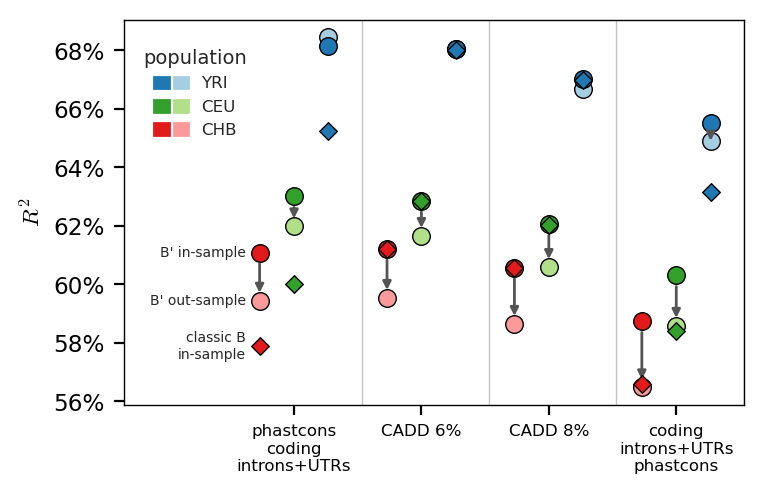

In [417]:
from matplotlib.patches import ConnectionPatch
import matplotlib.ticker as mtick
import matplotlib.cm as cm
cmap = cm.get_cmap('Paired')
pop_cols = cmap(np.arange(6))

fig, ax = plt.subplots(figsize=(4,2.5))

ms = 40
offset = 0.27
center = len(all_pops) / 2

x_min = 1000
i = 0
res = []
for pop in pop_to_num.keys():
    ci = i*2
    dfx = df.loc[(df['fit_type'] == 'sparse') & (df['pop'] == pop)]
    ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mbp_loo_R2'], color=pop_cols[ci, :], s=ms, linewidths=0.5, edgecolors='k')
    scatter = ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mbp_R2'], color=pop_cols[ci+1, :], label=pop.upper(), s=ms, linewidths=0.5, edgecolors='k')
    res.append(scatter)
    ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mb_R2'], marker="D", linewidths=0.5, color=pop_cols[ci+1, :], 
               edgecolors='k', zorder=100, s=0.5*ms)
    
    i += 1

    x_start = (dfx['model_num'] - offset*(dfx['pop_num'] - center)).tolist()
    x_end = x_start
    y_start = dfx['mbp_R2'].tolist()
    y_end = dfx['mbp_loo_R2'].tolist()

    coordsA = "data"
    coordsB = "data"

    for j in range(len(x_start)):
        if pop == 'yri' and dfx['model'].tolist()[j] != 'CDS > genes > phastcons':
            # omit arrows
            continue
        pop == 'yri' and dfx['model'].tolist()[j] != 'CDS > genes > phastcons'
        con = ConnectionPatch((x_start[j], y_start[j]), (x_end[j], y_end[j]), "data", "data",
                              arrowstyle="-|>", 
                              shrinkA=4, shrinkB=2.8,
                              mutation_scale=6, fc="0.33", ec='0.33')
        if x_min > x_start[j]:
            in_sample = (x_start[j], y_start[j])
            out_sample = (x_end[j], y_end[j])
            first = x_min = x_start[j]
        ax.add_artist(con)
     
ax.set_xticks(np.array(list(model_to_num.values())) + offset/2)
ax.set_xticklabels([x.replace(' > ', '\n').replace('genes', 'introns+UTRs').replace('CDS', 'coding') for x in model_to_num.keys()], fontsize=6)
ax.set_xlim(-1, ax.get_xlim()[1] + 0.2)

def format_func(value, tick_number):
    return "%.f%%" % (value * 100)

fs = 5
sp = 0.11
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_func))
ax.annotate("B' out-sample", out_sample, (out_sample[0]-sp, out_sample[1]), 
            ha='right', va='center',
           fontsize=fs)

ax.annotate("B' in-sample", in_sample, (in_sample[0]-sp, in_sample[1]),
            ha='right',va='center',
           fontsize=fs)

dfx = df.loc[(df['fit_type'] == 'sparse') & (df['pop'] == pop) & (df['model'] == "phastcons > CDS > genes")]
ax.annotate("classic B\nin-sample", (out_sample[0]-sp, dfx['mb_R2']),
            ha='right',va='center',
           fontsize=fs)
ax.set_ylabel("$R^2$")

import matplotlib.patches as mpatches
patches = []
populations = list(pop_to_num.keys())
for i in range(0, len(pop_cols), 2):
    #patches.append((mpatches.Patch(color=pop_cols[i+1, :], label=f'{populations[i//2].upper()}')))
    patch1 = mpatches.Patch(color=pop_cols[i+1, :])
    patch2 = mpatches.Patch(color=pop_cols[i, :])
    patches.append((patch1, patch2))

sep_lines = np.arange(0.666, 4, 1)
for i in sep_lines:
    ax.axvline(i, linestyle='solid', linewidth=0.5, c='0.77')
from matplotlib.legend_handler import HandlerTuple
legend = ax.legend(loc=(0.005, 0.65), fontsize=6, title='population', title_fontsize=7, 
                    handles=patches, labels=[x.upper() for x in populations], handler_map={tuple: HandlerTuple(ndivide=2, pad=0.3)})
ax.set_xlim(-1.2, sep_lines[-1])
plt.savefig('../manuscript/figures/figure_2_R2.pdf', bbox_inches='tight')

In [424]:
models['phastcons > CDS > genes'].fits[('yri', '1000000', 'full')]

{'mb': SimplexModel (interpolated w): 6 x 8 x 4
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250695262552.60873
 number of successful starts: 10000 (100.0% total)
 π0 = 0.00151829
 π  = 0.00106447
 μ_del  = 1.666e-09 
 Ne = 37,957 (if μ=1e-8), Ne = 18,978 (if μ=2e-8)
 R² = 63.6663% (in-sample)
 W = 
           CDS    gene    other    phastcons
 ------  -----  ------  -------  -----------
 1e-08       0   0            0        0
 1e-07       0   0            0        0
 1e-06       0   0            0        0
 1e-05       0   0            0        0.016
 0.0001      0   0            0        0.984
 0.001       0   0.132        0        0
 0.01        0   0.408        0        0
 0.1         1   0.46         1        0,
 'mbp': SimplexModel (interpolated w): 6 

## DFE Figure

Let's see if the DFEs we get out make sense. There is a tradeoff in terms of interpretability (e.g. not CADD or phastcons) and goodness of fit.

In [239]:
models.keys()

dict_keys(['phastcons > CDS > genes', 'phastcons > utrs > genes', 'CDS > genes > phastcons', 'CADD 6%', 'CADD 8%'])

Let's look at the two CADD models:

In [247]:
models['CADD 6%'].fits[('yri', '1000000', 'sparse')]

{'mb': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250663359423.69537
 number of successful starts: 20000 (100.0% total)
 π0 = 0.00142208
 π  = 0.00106447
 μ_del  = 2.072e-08 
 Ne = 35,552 (if μ=1e-8), Ne = 17,776 (if μ=2e-8)
 R² = 68.0109% (in-sample)
 W = 
           cadd6
 ------  -------
 1e-08     0
 1e-07     0
 1e-06     0
 1e-05     0
 0.0001    0.031
 0.001     0.306
 0.01      0.031
 0.1       0.632,
 'mbp': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-

In [248]:
models['CADD 8%'].fits[('yri', '1000000', 'sparse')]

{'mb': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250673909123.87784
 number of successful starts: 10000 (100.0% total)
 π0 = 0.00141438
 π  = 0.00106447
 μ_del  = 1.547e-08 
 Ne = 35,359 (if μ=1e-8), Ne = 17,679 (if μ=2e-8)
 R² = 66.9809% (in-sample)
 W = 
           cadd8
 ------  -------
 1e-08     0
 1e-07     0
 1e-06     0
 1e-05     0
 0.0001    0.048
 0.001     0.303
 0.01      0
 0.1       0.649,
 'mbp': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-like

In [235]:
models['phastcons > CDS > genes'].fits.keys()

dict_keys([('chb', '1000000', 'full'), ('chb', '1000000', 'sparse'), ('yri', '1000000', 'full'), ('yri', '1000000', 'sparse'), ('ceu', '1000000', 'full'), ('ceu', '1000000', 'sparse')])

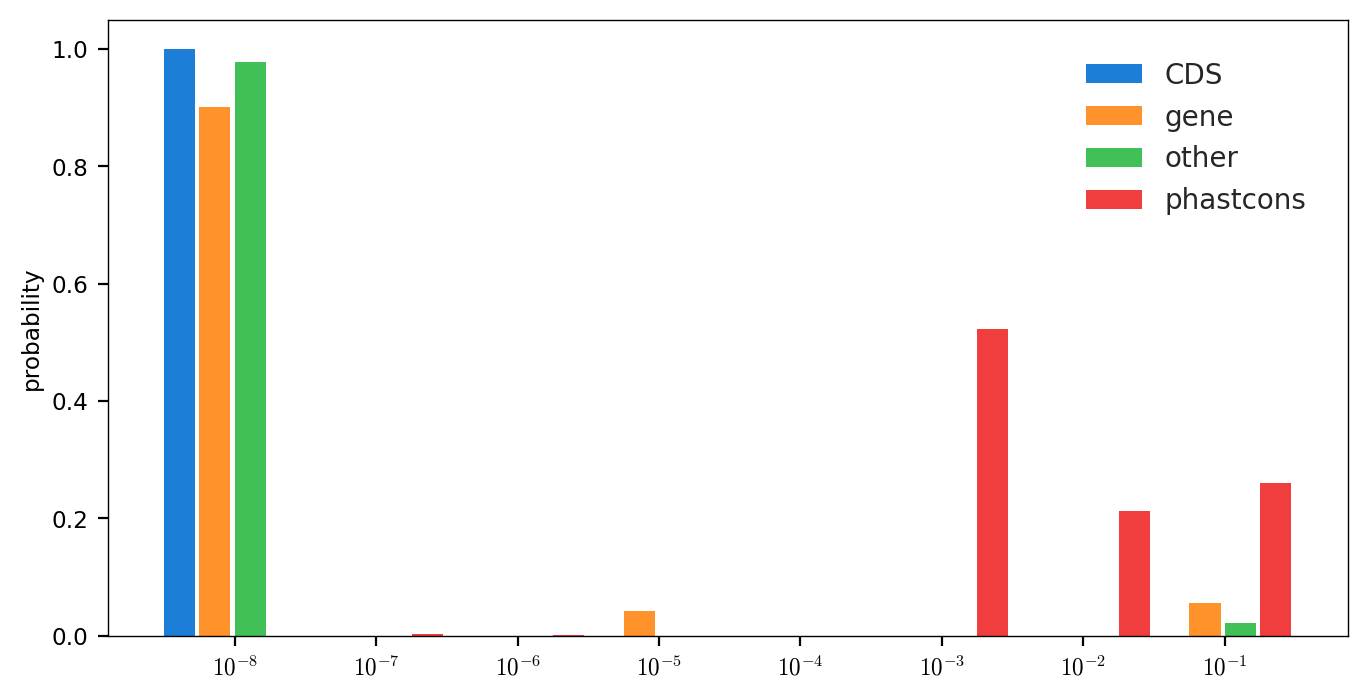

In [267]:
models['phastcons > CDS > genes'].fits[('yri', '1000000', 'full')]['mbp'].dfe_plot()

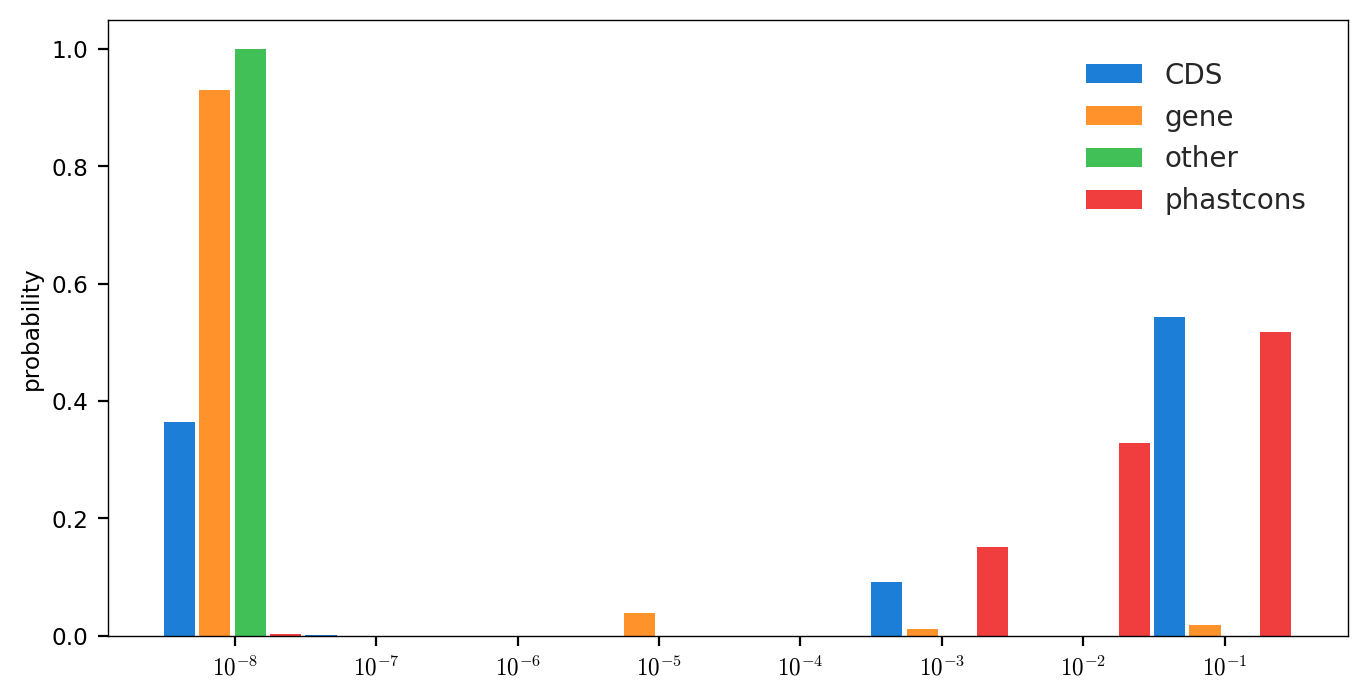

In [241]:
models['CDS > genes > phastcons'].fits[('yri', '1000000', 'full')]['mbp'].dfe_plot()

In [280]:
models[

{'phastcons > CDS > genes': <bgspy.pipeline.ModelDir at 0x7f77f7cd2cb0>,
 'phastcons > utrs > genes': <bgspy.pipeline.ModelDir at 0x7f77f7c468c0>,
 'CDS > genes > phastcons': <bgspy.pipeline.ModelDir at 0x7f77f7c46b90>,
 'CADD 6%': <bgspy.pipeline.ModelDir at 0x7f7733084f40>,
 'CADD 8%': <bgspy.pipeline.ModelDir at 0x7f77f7f78d30>}

In [284]:
models['CADD 6%'].fits.keys()

dict_keys([('chb', '100000', 'sparse'), ('chb', '1000000', 'full'), ('chb', '1000000', 'sparse'), ('yri', '100000', 'sparse'), ('yri', '1000000', 'full'), ('yri', '1000000', 'sparse'), ('ceu', '100000', 'sparse'), ('ceu', '1000000', 'full'), ('ceu', '1000000', 'sparse')])

In [295]:
dfes = defaultdict(lambda: defaultdict(dict))
dfe_errors = defaultdict(lambda: defaultdict(dict))

fits = dict()
for model_name, model in models.items():
    for pop in all_pops:
        fit = model.fits[(pop, '1000000', 'full')]['mbp']
        fits[(model, pop)] = fit
        res = fit.W_stderrs()
        if res is None:
            continue
        means, errors = res
        for feature in means:
            dfes[model][feature][pop] = means[feature]
            dfe_errors[model][feature][pop] = errors[feature]

IndexError: list index out of range

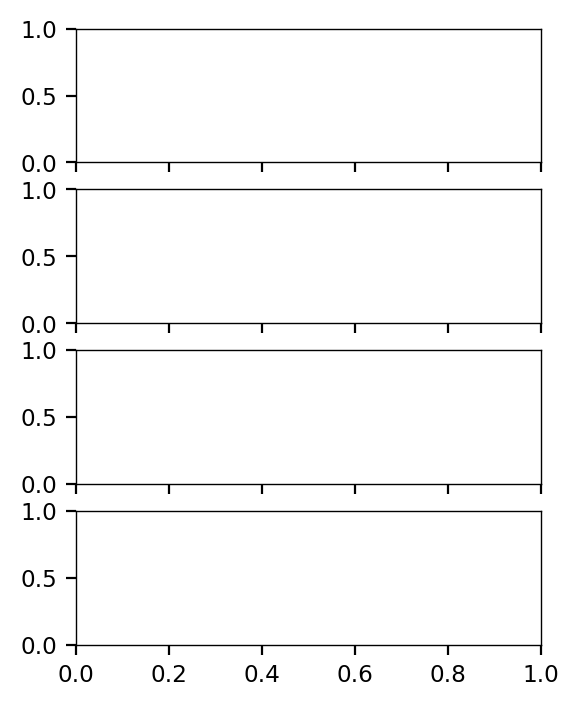

In [292]:
from bgspy.plots import get_figax

def dfe_plot_alt(x_labels, groups, errors=None, keys=None, figax=None):
    fig, ax = get_figax(figax)
    nf = len(groups)
    x = np.arange(len(x_labels))
    
    width = 0.2  # the width of the bars
    mid_offset = -1
    multiplier = mid_offset

    bar_pos = []
    keys = groups.keys() if keys is None else keys
    for feature in keys:
        means = groups[feature]
        offset = width * multiplier
        pos = x + offset
        bar_pos.append(pos)
        rects = ax.bar(pos, means, width, label=feature.upper())
        if errors:
            ax.errorbar(pos, means, errors[feature], 
                        fmt='none', capsize=0, elinewidth=0.8, alpha=0.8, 
                        color='0.44')
        multiplier += 1
    
    ends = list(zip(bar_pos[0], bar_pos[-1]))    
    for i in range(len(x)):
        s, e = ends[i]
        #ax.plot((s-width/2, e+ width/2), (0, 0), c='k')

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.set_xticks(x + width, x_labels)
    ax.set_ylim(-0.001, None)
    

    
    
    
model_name = 'phastcons > CDS > genes'

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(3, 4), sharex=True,)

feature_labels = {'phastcons': 'phastcons', 'cds': 'coding', 'gene':'introns+UTRs', 'other':'other'}
features = dfes['full-hapmap']
for i, feature in enumerate(feature_labels.keys()):
    dfe_plot_alt(np.arange(-8, 0), 
                 dfes[model_name][feature], 
                 errors=dfe_errors[model_name][feature],
                 figax=(fig, ax[i]))
    ax[i].text(0.5, 0.8, feature_labels[feature], transform=ax[i].transAxes, ha='center', fontsize=8)
    ax[i].set_ylim(0, 1.1)
    ax[i].set_yticks((0.0, 0.5, 1.0), (0, 0.5, 1), fontsize=6)
    if i < 3:
        ax[i].xaxis.set_ticks_position('none') 
    
ax[3].legend(ncols=1, prop={'size': 6})
fig.subplots_adjust(wspace=0, hspace=0.1)
ts = np.arange(-8, 0)
ax[3].set_xticks(range(len(ts)), [f"$10^{{{f}}}$" for f in ts], fontsize=6)

### Phastcons + CDS + genes


In [457]:
pcg = dict()
pcg_full = dict()
for pop in pops:
    pcg[pop] = load_pickle(f'../new_fits/phastcons_CDS_genes__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')
    pcg_full[pop] = load_pickle(f'../new_fits/phastcons_CDS_genes__decode//fits/pop_{pop}/window_1000000/type_full/mutrate_free/initial/mle.pkl')

In [412]:
for pop in pops:
    nll_sparse, nll_full = pcg[pop]['mbp'].nll_, pcg_full[pop]['mbp'].nll_
    print((pop, nll_sparse, nll_full, nll_full < nll_sparse))

('yri', 250657908564.79294, 250656989872.19766, True)
('ceu', 197826612684.87143, 197825873893.4953, True)
('chb', 61822016128.79776, 61821783504.67356, True)


(<Figure size 1600x800 with 6 Axes>,
 array([<Axes: ylabel='CDS'>, <Axes: ylabel='gene'>,
        <Axes: ylabel='other'>, <Axes: ylabel='phastcons'>,
        <Axes: ylabel='$\\pi_0$ ($\\times^{-3}$)'>,
        <Axes: ylabel='$\\mu$ ($\\times^{-8}$)'>], dtype=object))

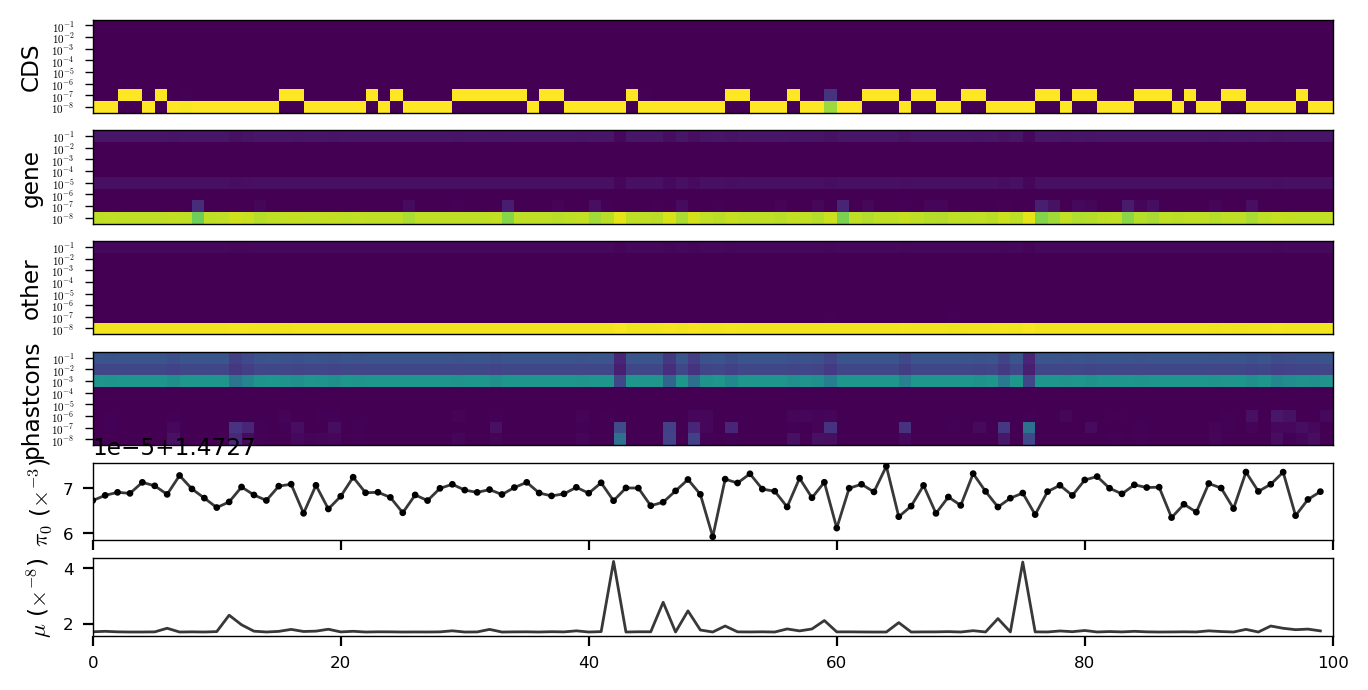

In [460]:
optim_diagnotics_plot(pcg_full['yri']['mbp'])

### Coefficient of Variation in Fits

The coefficient of variation of the predicted landscape is a function of spatial recombination and segments. Larger predictived CVs are determined by this.

In [399]:
cvs = dict()
for pop in pops:
    cvs[pop] = pcg[pop]['mbp'].coefvar()

Text(0.55, 0.15, 'Correlation: 0.75')

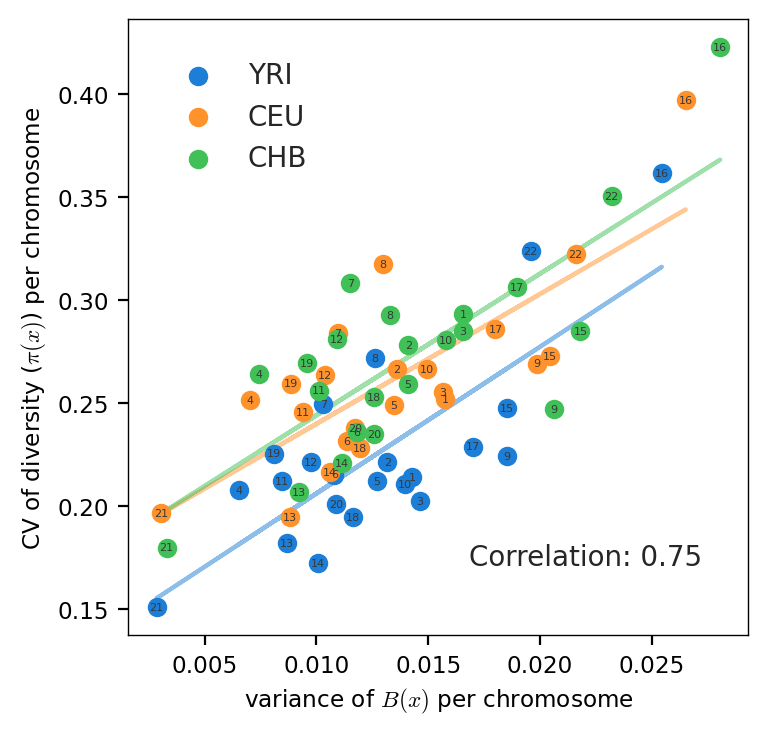

In [400]:
import matplotlib.patheffects as PathEffects
fig, ax = plt.subplots(figsize=(4, 4))
x, y = [], []


for pop in pops:
    d, p = list(cvs[pop][0].values()), list(cvs[pop][1].values())
    x.extend(d)
    y.extend(p)
    scatter = ax.scatter(p, d, label=pop.upper())
    for i, chrom in enumerate(cvs[pop][0].keys()):
        pass
        txt = ax.annotate(chrom.replace('chr', ''), xy=(p[i], d[i]), fontsize=4, color='0.22', va='center', ha='center')
        #txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='0.22')])
    m, b, *a = stats.linregress(p, d)
    ax.plot(p, [m * xi + b for xi in p], color=scatter.get_facecolor()[0], alpha=0.5, zorder=-10)

ax.set_xlabel('variance of $B(x)$ per chromosome')
ax.set_ylabel('CV of diversity ($\pi(x)$) per chromosome')
#ax.axline((0.05, 0.05), slope=1, c='0.22')
ax.legend(ncol=1)

cc = np.corrcoef(x, y)[0, 1]
ax.text(
    
    0.55,
    0.15,
    f"Correlation: {cc:.2f}",
    transform=ax.transAxes,
    verticalalignment="top",
)

In [105]:
stats.linregress(p, d).rvalue**2

0.5606841030998159

This is a version for talks, etc to show that populations do not have specific fits.

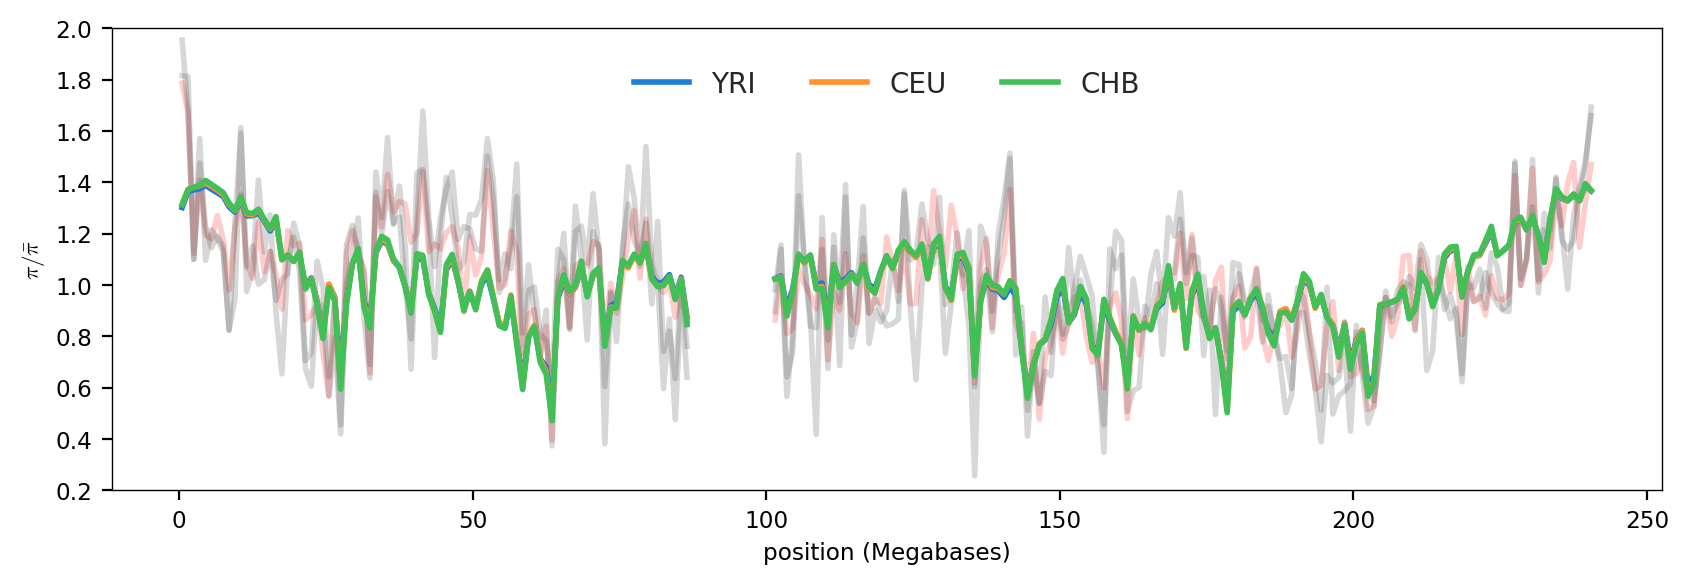

In [542]:
chrom = 'chr2'
cols = sns.color_palette()
    
figax = plt.subplots(figsize=(10, 3))
fig, ax = figax
pis = []
ax.set_ylim(0.2, 2)
for i, pop in enumerate(pops):
    fit = pcg[pop]['mbp']
    midpoints, pi = fit.bins.pi_pairs(chrom)
    pis.append(pi)
    if pop == 'yri':
        fit.predict_plot(chrom, figax=figax, pi_col='r', pred_col=cols[i], alpha_pi=0.2, label=pop.upper())
    else:
        fit.predict_plot(chrom, figax=figax, pi_col='0.22', pred_col=cols[i], alpha_pi=0.2, label=pop.upper())
    

    ax.legend()
    old_handles, old_labels = ax.get_legend_handles_labels()

    handles, labels = [], []
    for h, l in zip(old_handles, old_labels):
        if l == 'data':
            continue
        h.set_linewidth(2)
        handles.append(h)
        labels.append(l)
    ax.legend(handles, labels, ncols=4, loc='upper center')
    ax.set_xlabel("position (Megabases)")
    
    plt.savefig(f"../manuscript/figures/supplementary/talks/phastcons_model_fits_{i}.pdf")

/tmp/ipykernel_57287/4286726797.py:19: RuntimeWarning: Mean of empty slice
  ax.plot(to_mb(midpoints), mean_ratio(np.nanmean(np.stack(pis), axis=0)), c='0.22', label='average')


(<Figure size 2000x600 with 1 Axes>,
 <Axes: xlabel='position', ylabel='$\\pi/\\bar{\\pi}$'>)

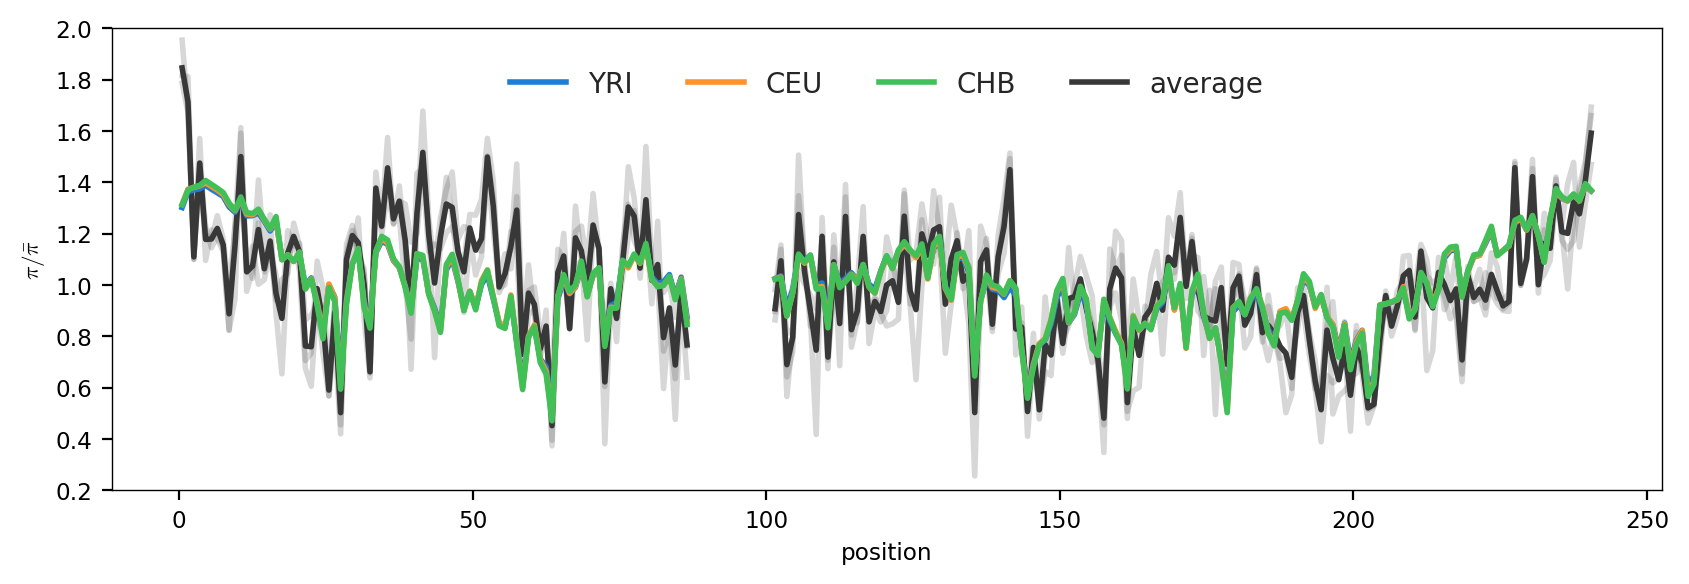

In [584]:
chrom = 'chr2'

def joint_prediction_plot(fits, chrom, pops=None, 
                          figax_kwargs=dict(figsize=(10, 3)), figax=None):
    if pops is None:
        pops = fits.keys()
    if isinstance(pops, str):
        pops = [pops]
    figax = get_figax(figax, **figax_kwargs)
    cols = sns.color_palette()
    fig, ax = figax
    pis = []
    for i, pop in enumerate(pops):
        fit = fits[pop]['mbp']
        midpoints, pi = fit.bins.pi_pairs(chrom)
        pis.append(pi)
        fit.predict_plot(chrom, figax=figax, pi_col='0.22', pred_col=cols[i], alpha_pi=0.2, label=pop.upper())

    ax.plot(to_mb(midpoints), mean_ratio(np.nanmean(np.stack(pis), axis=0)), c='0.22', label='average')
    old_handles, old_labels = ax.get_legend_handles_labels()

    handles, labels = [], []
    for h, l in zip(old_handles, old_labels):
        if l == 'data':
            continue
        h.set_linewidth(2)
        handles.append(h)
        labels.append(l)
    ax.legend(handles, labels, ncols=4, loc='upper center')
    return fig, ax

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_ylim(0.2, 2)
joint_prediction_plot(pcg, chrom, figax=(fig, ax))


#plt.savefig(f"../manuscript/figures/supplementary/talks/phastcons_model_fits_all.pdf")

In [470]:
{k: f['mbp'].R2() for k, f in pcg.items()}

{'yri': 0.6815821976013484,
 'ceu': 0.6301522801539102,
 'chb': 0.6108036144484064}

### CADD8

In [402]:
cd8 = dict()
cd8_full = dict()
cd8_rescale = dict()
for pop in pops:
    cd8[pop] = load_pickle(f'../new_fits/cadd8__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')
    cd8_full[pop] = load_pickle(f'../new_fits/cadd8__decode/fits/pop_{pop}/window_1000000/type_full/mutrate_free/initial/mle.pkl')
    cd8_rescale[pop] = load_pickle(f'../new_fits/cadd8__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/rescaled/mle.pkl')

In [318]:
pop = 'yri'
cd8[pop]['mbp'], cd8_rescale[pop]['mbp']

(SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250673972070.93787
 number of successful starts: 10000 (100.0% total)
 π0 = 0.00141668
 π  = 0.00106447
 μ_del  = 1.569e-08 
 Ne = 35,416 (if μ=1e-8), Ne = 17,708 (if μ=2e-8)
 R² = 67.0084% (in-sample)
 W = 
           cadd8
 ------  -------
 1e-08     0
 1e-07     0
 1e-06     0
 1e-05     0
 0.0001    0.059
 0.001     0.298
 0.01      0
 0.1       0.643,
 SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 25064

Text(0.5, 0, 'predicted $B$')

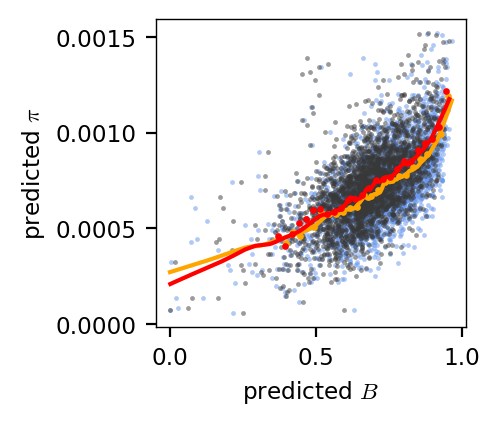

In [482]:
use_B = True
pop = 'chb'
fig, ax = plt.subplots(figsize=(2, 2))
predicted_observed(cd8[pop]['mbp'], figax=(fig, ax), use_B=use_B, c='cornflowerblue')
predicted_observed(cd8_rescale[pop]['mbp'], figax=(fig, ax), use_B=use_B, smooth_col='r', n_bins=40)
ax.set_ylabel('predicted $\pi$')
ax.set_xlabel('predicted $B$')
#ax.set_xlim((0.00025, 0.00105))
#ax.set_ylim((0.00019, 0.0016))

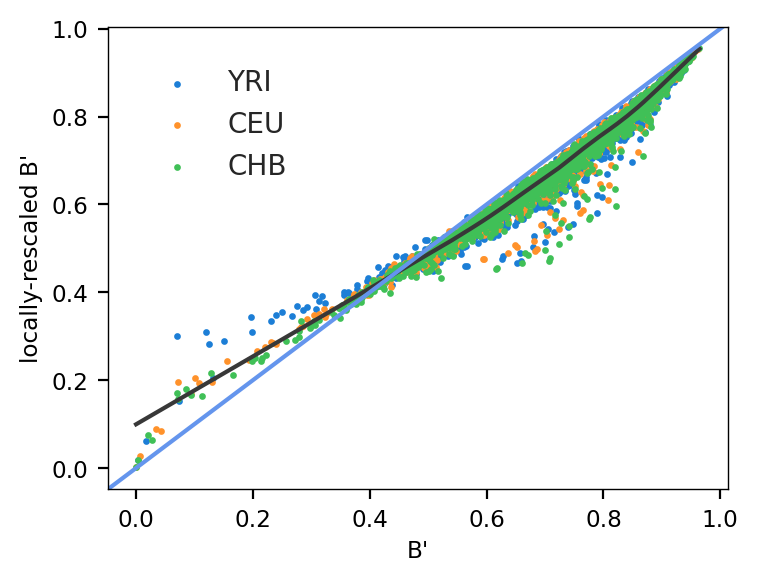

In [453]:
fig, ax = plt.subplots(figsize=(4, 3))
x, y = [], []
for pop in pops:
    ax.scatter(cd8[pop]['mbp'].predict(B=True), cd8_rescale[pop]['mbp'].predict(B=True), label=pop.upper(), s=2, alpha=1)
    x.extend(cd8[pop]['mbp'].predict(B=True))
    y.extend(cd8_rescale[pop]['mbp'].predict(B=True))


ax.plot(*smooth(x, y, frac=0.2), c='0.22')
ax.axline((0, 0), slope=1, c='cornflowerblue')
ax.set_ylabel("locally-rescaled B'")
ax.set_xlabel("B'")
ax.legend()

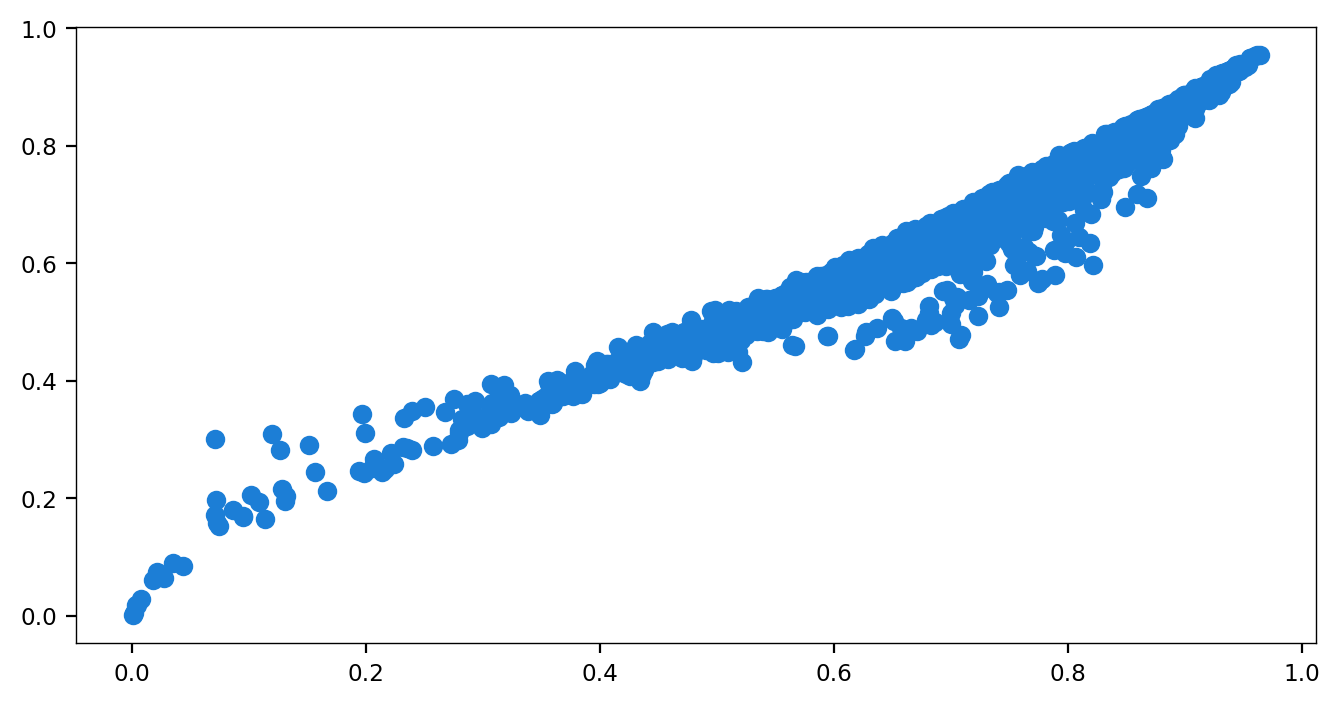

In [450]:
plt.scatter(x, y)

This change is interesting —  I think the HRI-type effects could be tipping the scales right around $Ns \approx 1$. 

First, things could be sensitive to my initial choice of neutral $N_e = 10,000$. What is the drift $N_e$ implied by this data?

In [395]:

for pop in pops:
    print((pop, cd8[pop]['mbp'].mle_pi0 / (4 * 1.3e-8)))

('yri', 27243.81489682956)
('ceu', 20587.968203528977)
('chb', 19345.549940170826)


So approximately, $20,000$ for bottlenecked pops, and ~27,000 for YRI.

Text(0.5, 0, '$B_r(x) - B(x)$')

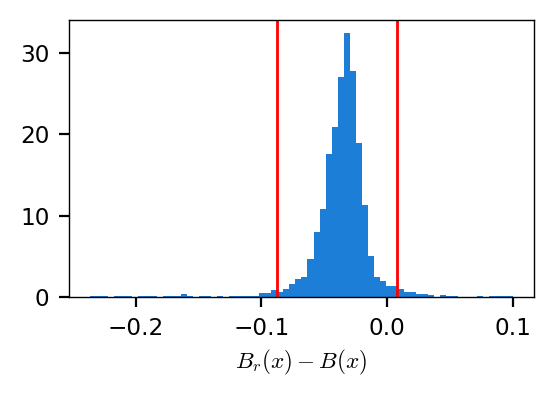

In [353]:
fig, ax = plt.subplots(figsize=(3, 1.8))
bins = cd8[pop]['mbp'].bins
b, br = cd8[pop]['mbp'].predict(B=True), cd8_rescale[pop]['mbp'].predict(B=True)
diff = br-b
_ = ax.hist(diff, 70, density=True)
cutoffs = np.quantile(diff, (0.02, 0.98))
ax.axvline(cutoffs[0], linewidth=1, c='r')
ax.axvline(cutoffs[1], linewidth=1, c='r')
ax.set_xlabel("$B_r(x) - B(x)$")

In [354]:
lower_idx = diff < cutoffs[0] 

In [361]:
#from bgspy.plots import predict_sparkplot
#predict_sparkplot(cd8[pop]['mbp'])

In [358]:
[bin for bin, keep in zip(bins.flat_bins(), lower_idx.tolist()) if keep]

[('chr1', 1000000, 2000000),
 ('chr1', 19000000, 20000000),
 ('chr1', 235000000, 236000000),
 ('chr2', 0, 1000000),
 ('chr2', 45000000, 46000000),
 ('chr2', 232000000, 233000000),
 ('chr3', 0, 1000000),
 ('chr4', 0, 1000000),
 ('chr4', 9000000, 10000000),
 ('chr5', 0, 1000000),
 ('chr5', 146000000, 147000000),
 ('chr5', 171000000, 172000000),
 ('chr5', 180000000, 181000000),
 ('chr6', 0, 1000000),
 ('chr7', 0, 1000000),
 ('chr7', 152000000, 153000000),
 ('chr8', 0, 1000000),
 ('chr8', 130000000, 131000000),
 ('chr8', 140000000, 141000000),
 ('chr9', 0, 1000000),
 ('chr9', 83000000, 84000000),
 ('chr10', 0, 1000000),
 ('chr11', 0, 1000000),
 ('chr11', 108000000, 109000000),
 ('chr11', 134000000, 135000000),
 ('chr12', 0, 1000000),
 ('chr12', 116000000, 117000000),
 ('chr12', 118000000, 119000000),
 ('chr12', 132000000, 133000000),
 ('chr13', 113000000, 114000000),
 ('chr14', 71000000, 72000000),
 ('chr15', 101000000, 101991189),
 ('chr16', 0, 1000000),
 ('chr16', 14000000, 15000000),
 (

### CADD6 

In [401]:
cd6 = dict()
for pop in pops:
    cd6[pop] = load_pickle(f'../new_fits/cadd6__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/initial/mle.pkl') 

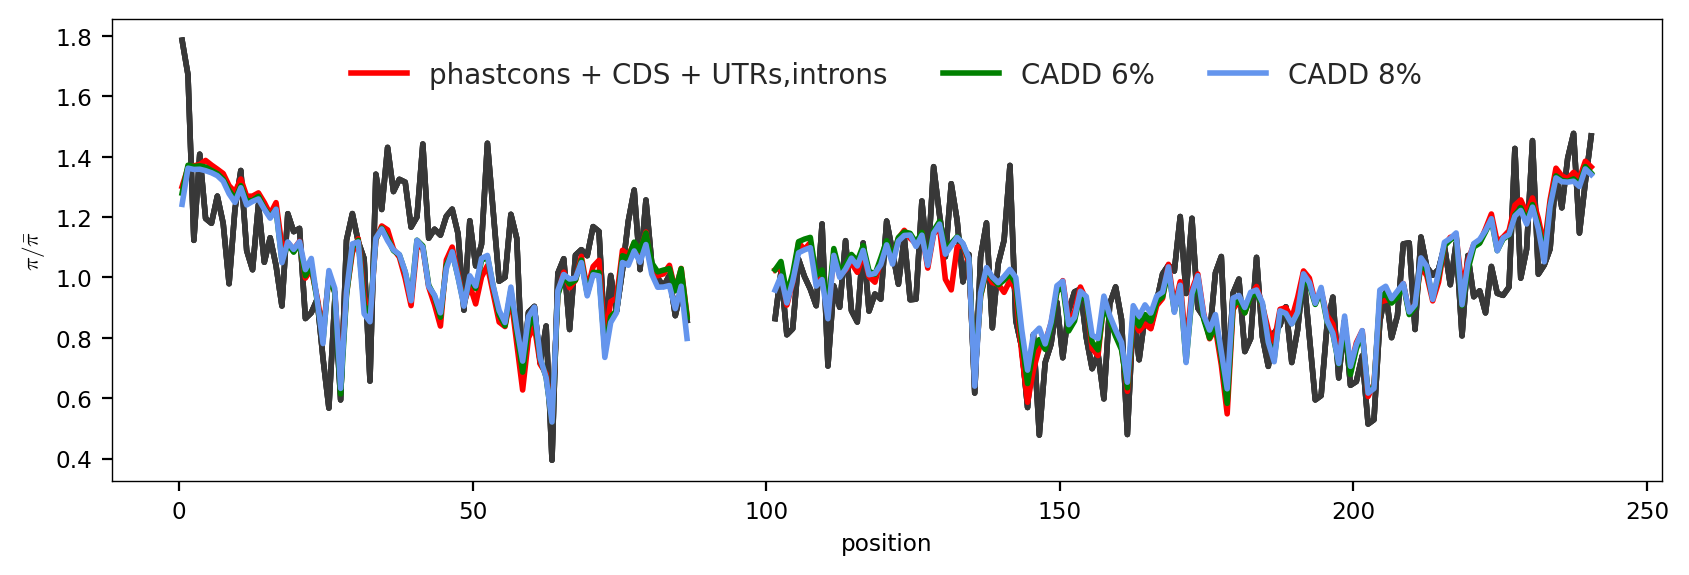

In [472]:
figax = plt.subplots(figsize=(10,3))
fig, ax = figax
pcg['yri']['mbp'].predict_plot('chr2', pred_col='r', figax=figax, label='phastcons + CDS + UTRs,introns')
#pcg_full['yri']['mbp'].predict_plot('chr2', pred_col='orange', figax=figax, label='phastcons + CDS + UTRs,introns')
cd6['yri']['mbp'].predict_plot('chr2', pred_col='g', figax=figax, label='CADD 6%')
cd8['yri']['mbp'].predict_plot('chr2', figax=figax, label='CADD 8%')
ax.legend(ncols=3)

old_handles, old_labels = ax.get_legend_handles_labels()

handles, labels = [], []
for h, l in zip(old_handles, old_labels):
    if l == 'data':
        continue
    h.set_linewidth(2)
    handles.append(h)
    labels.append(l)
ax.legend(handles, labels, ncols=4, loc='upper center')

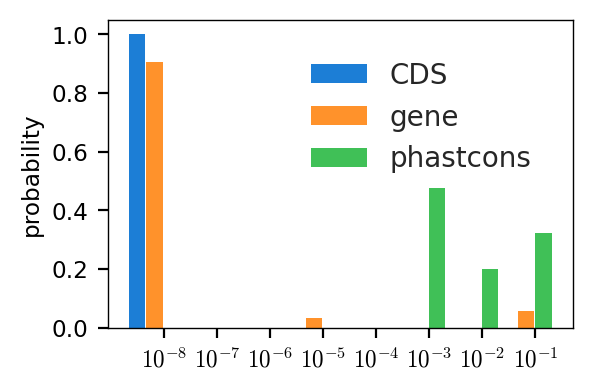

In [477]:
figax = plt.subplots(figsize=(3,2))
pcg['yri']['mbp'].dfe_plot(figax=figax)

In [478]:
def dfe_plot_alt(x_labels, groups, errors=None, keys=None, figax=None):
    fig, ax = get_figax(figax)
    nf = len(groups)
    x = np.arange(len(x_labels))
    
    width = 0.2  # the width of the bars
    mid_offset = -1
    multiplier = mid_offset

    bar_pos = []
    keys = groups.keys() if keys is None else keys
    for feature in keys:
        means = groups[feature]
        offset = width * multiplier
        pos = x + offset
        bar_pos.append(pos)
        rects = ax.bar(pos, means, width, label=feature.upper())
        if errors:
            ax.errorbar(pos, means, errors[feature], 
                        fmt='none', capsize=0, elinewidth=0.8, alpha=0.8, 
                        color='0.44')
        multiplier += 1
    
    ends = list(zip(bar_pos[0], bar_pos[-1]))    
    for i in range(len(x)):
        s, e = ends[i]
        #ax.plot((s-width/2, e+ width/2), (0, 0), c='k')

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.set_xticks(x + width, x_labels)
    ax.set_ylim(-0.001, None)
    

TypeError: unsupported operand type(s) for +: 'int' and 'SimplexModel'

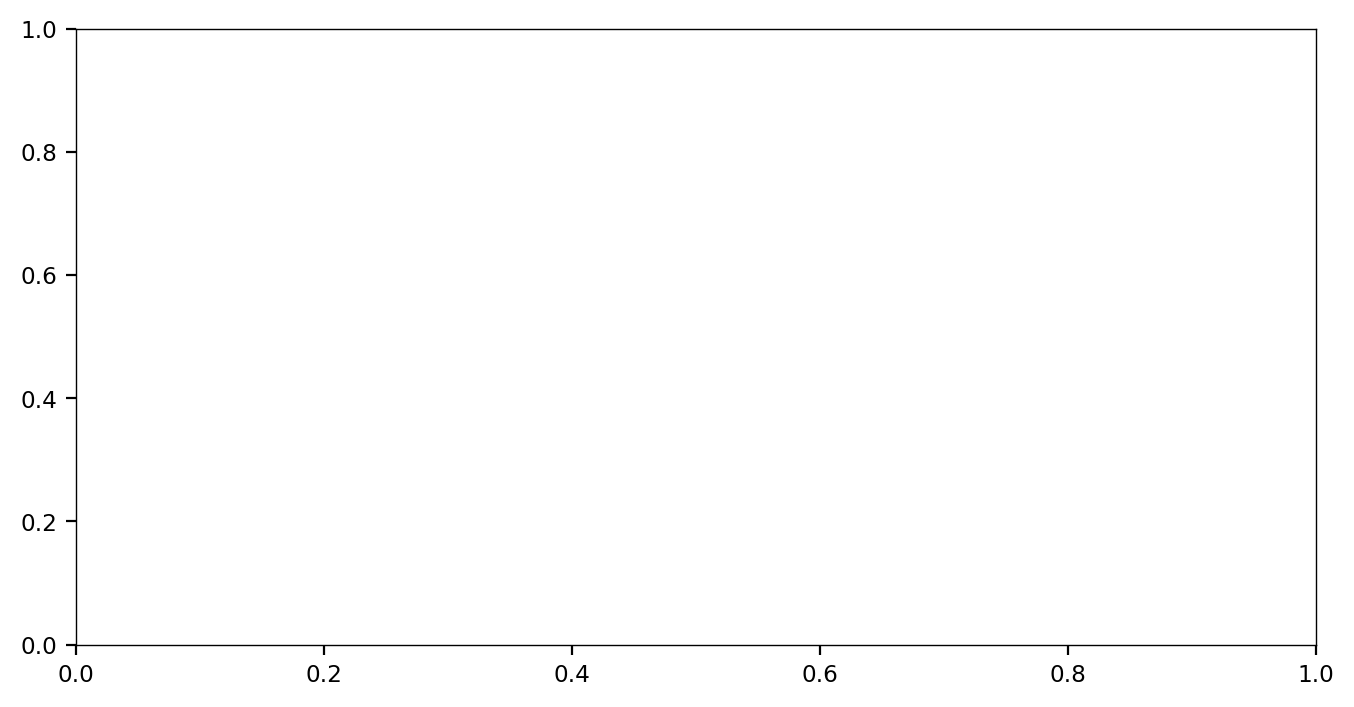

In [480]:
dfe_plot_alt(pcg['yri']['mbp'].t, {k: v['mbp'] for k, v in pcg.items()})

In [ ]:
dfes = defaultdict(lambda: defaultdict(dict))
dfe_errors = defaultdict(lambda: defaultdict(dict))

for model in fits:
    for pop in fits[model]:
        fit = fits[model][pop]
        res = fit.W_stderrs()
        if res is None:
            continue
        means, errors = res
        for feature in means:
            dfes[model][feature][pop] = means[feature]
            dfe_errors[model][feature][pop] = errors[feature]

In [ ]:
from bgspy.plots import get_figax

fit = fits['full-hapmap']['ceu']
means, errors = fit.W_stderrs()




fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(3, 4), sharex=True,)

feature_labels = {'phastcons': 'phastcons', 'cds': 'coding', 'gene':'introns+UTRs', 'other':'other'}
features = dfes['full-hapmap']
for i, feature in enumerate(feature_labels.keys()):
    dfe_plot_alt(np.arange(-8, 0), 
                 dfes['full-hapmap'][feature], 
                 errors=dfe_errors['full-hapmap'][feature],
                 figax=(fig, ax[i]))
    ax[i].text(0.5, 0.8, feature_labels[feature], transform=ax[i].transAxes, ha='center', fontsize=8)
    ax[i].set_ylim(0, 1.1)
    ax[i].set_yticks((0.0, 0.5, 1.0), (0, 0.5, 1), fontsize=6)
    if i < 3:
        ax[i].xaxis.set_ticks_position('none') 
    
ax[3].legend(ncols=1, prop={'size': 6})
fig.subplots_adjust(wspace=0, hspace=0.1)
ts = np.arange(-8, 0)
ax[3].set_xticks(range(len(ts)), [f"$10^{{{f}}}$" for f in ts], fontsize=6)

(<Figure size 1600x800 with 1 Axes>,
 <Axes: xlabel='predicted $\\hat{\\pi}$', ylabel='residuals'>)

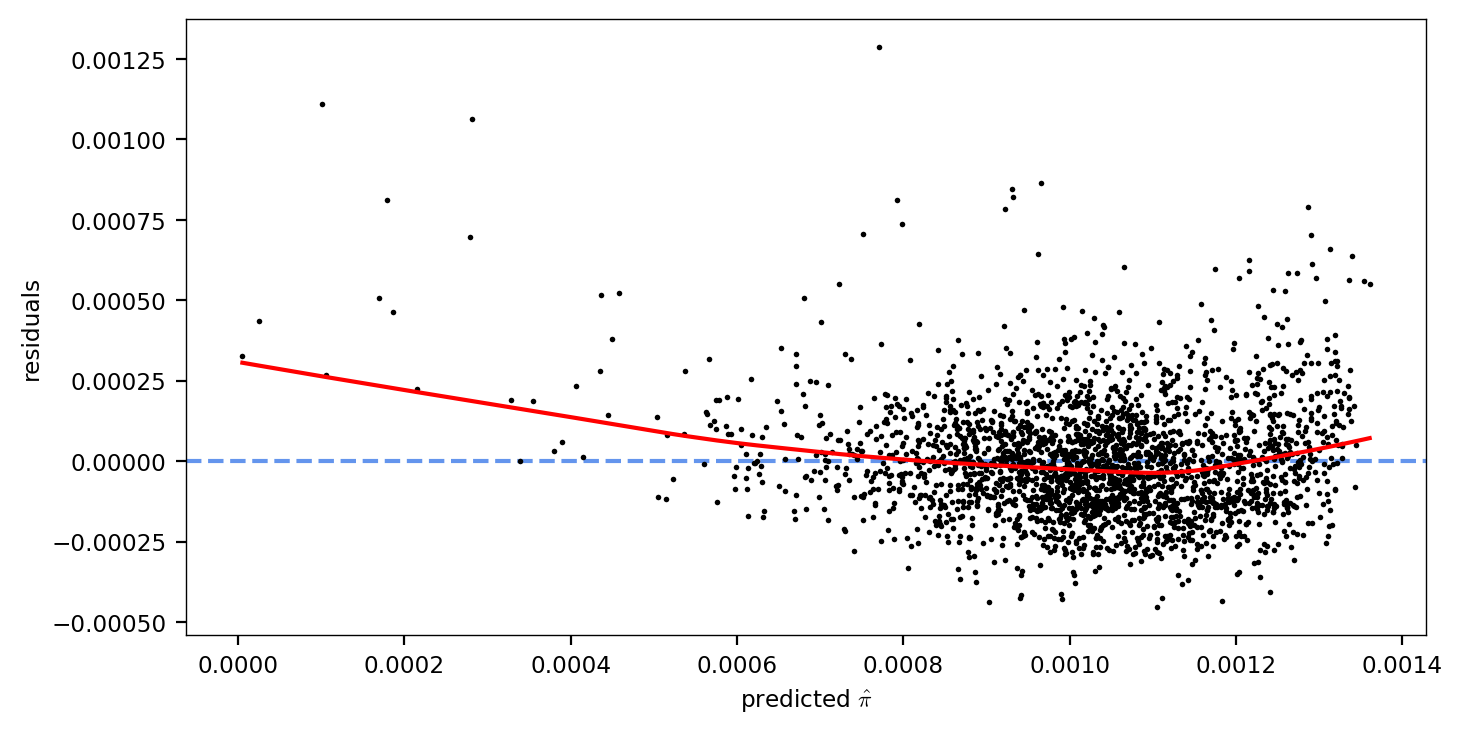

In [161]:
cd8['yri']['mbp'].resid_fitted_plot(color=False)


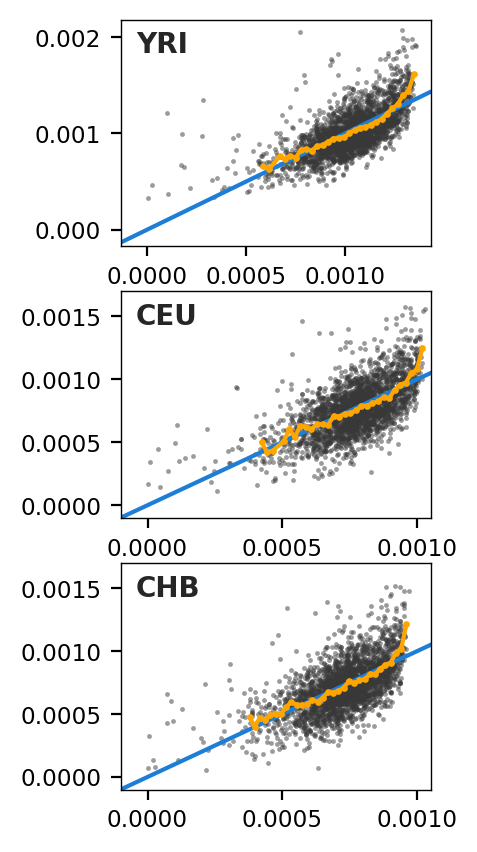

In [249]:
equal_num = False
smooth_col = 'orange'

fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(2, 5))# sharex=True, sharey=True)
for i, pop in enumerate(pops):
    predicted_observed(cd8[pop]['mbp'], figax=(fig, ax[i])) 
    ax[i].text(0.05, 0.95, pop.upper(), transform=ax[i].transAxes, 
               fontsize=10, fontweight='bold', va='top')
    if i >= 1:
        ax[i].set_xlim((-1e-4, 0.00105))
        ax[i].set_ylim((-1e-4, 0.0017))

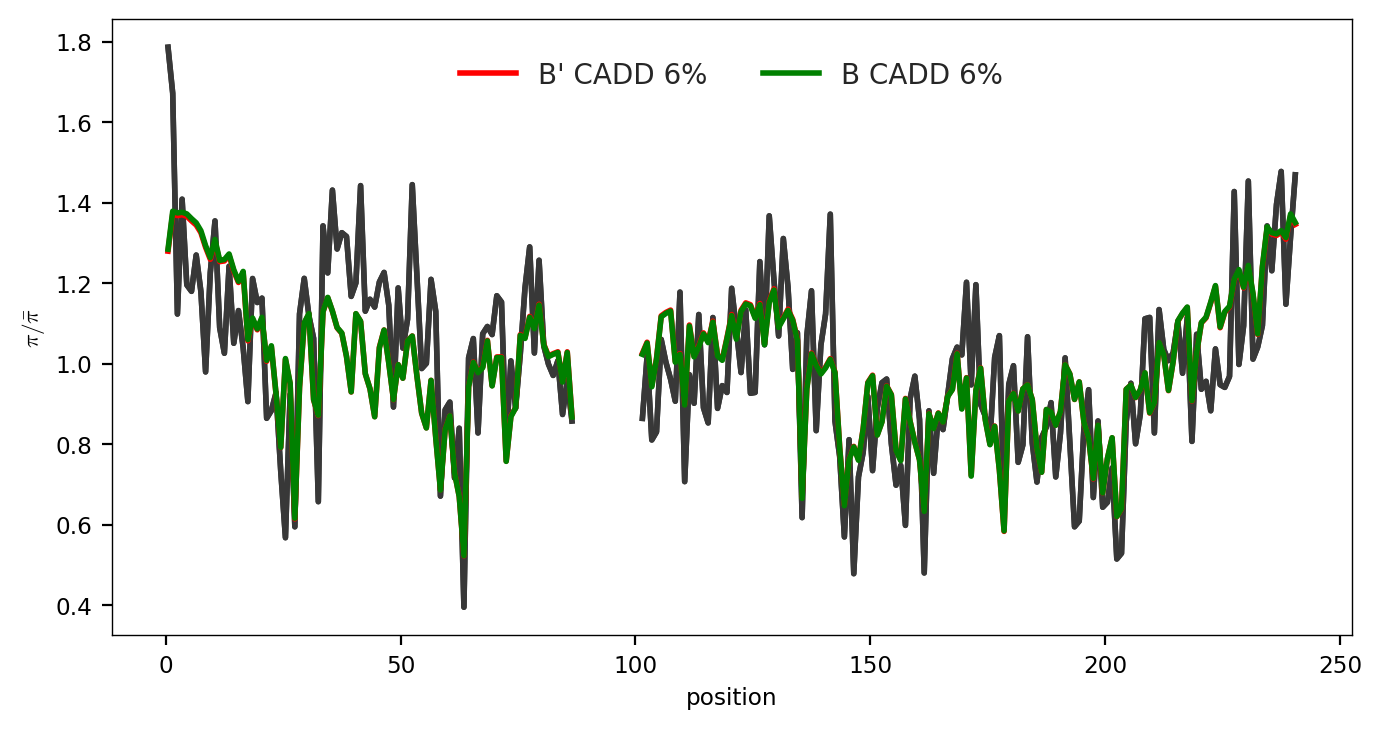

In [392]:
figax = plt.subplots()
fig, ax = figax
cd6['yri']['mbp'].predict_plot('chr2', pred_col='r', figax=figax, label="B' CADD 6%")
cd6['yri']['mb'].predict_plot('chr2', pred_col='g', figax=figax, label='B CADD 6%')
ax.legend(ncols=3)

old_handles, old_labels = ax.get_legend_handles_labels()

handles, labels = [], []
for h, l in zip(old_handles, old_labels):
    if l == 'data':
        continue
    h.set_linewidth(2)
    handles.append(h)
    labels.append(l)
ax.legend(handles, labels, ncols=4, loc='upper center')

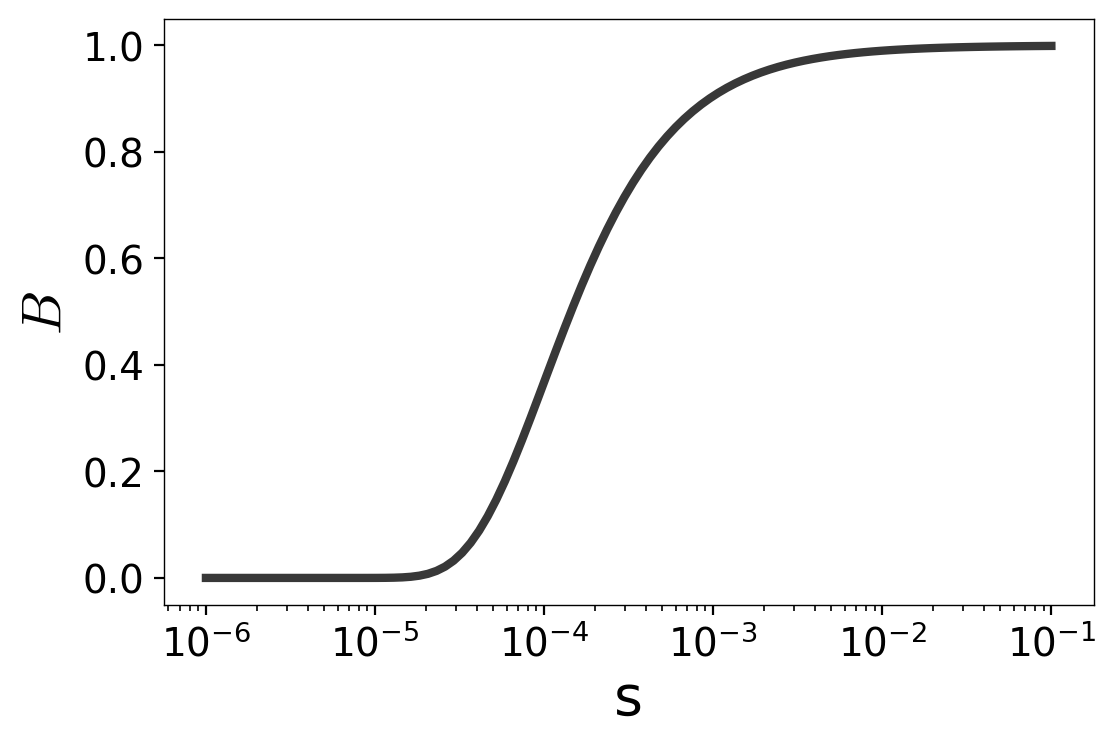

In [443]:
def bgs(s, u):
    return np.exp(-u/s)

fig, ax = plt.subplots(figsize=(6,3.8))
s = np.logspace(-6, -1, 100)
ax.plot(s, bgs(s, 1e-4), c='0.22', linewidth=3)
ax.semilogx()
ax.set_ylabel("$B$", fontsize=20)
ax.set_xlabel("s", fontsize=20) 
ax.tick_params(axis='both', which='major', labelsize=14)


In [425]:
np.exp(- 0.5 / s[-10:])

array([6.53986360e-07, 3.12266901e-06, 1.25586787e-05, 4.33516838e-05,
       1.30616156e-04, 3.48659775e-04, 8.35591405e-04, 1.81933466e-03,
       3.63691252e-03, 6.73794700e-03])

In [422]:
s

array([1.00000000e-06, 1.12332403e-06, 1.26185688e-06, 1.41747416e-06,
       1.59228279e-06, 1.78864953e-06, 2.00923300e-06, 2.25701972e-06,
       2.53536449e-06, 2.84803587e-06, 3.19926714e-06, 3.59381366e-06,
       4.03701726e-06, 4.53487851e-06, 5.09413801e-06, 5.72236766e-06,
       6.42807312e-06, 7.22080902e-06, 8.11130831e-06, 9.11162756e-06,
       1.02353102e-05, 1.14975700e-05, 1.29154967e-05, 1.45082878e-05,
       1.62975083e-05, 1.83073828e-05, 2.05651231e-05, 2.31012970e-05,
       2.59502421e-05, 2.91505306e-05, 3.27454916e-05, 3.67837977e-05,
       4.13201240e-05, 4.64158883e-05, 5.21400829e-05, 5.85702082e-05,
       6.57933225e-05, 7.39072203e-05, 8.30217568e-05, 9.32603347e-05,
       1.04761575e-04, 1.17681195e-04, 1.32194115e-04, 1.48496826e-04,
       1.66810054e-04, 1.87381742e-04, 2.10490414e-04, 2.36448941e-04,
       2.65608778e-04, 2.98364724e-04, 3.35160265e-04, 3.76493581e-04,
       4.22924287e-04, 4.75081016e-04, 5.33669923e-04, 5.99484250e-04,
      